# Resumo

O presente exercício procura fazer uma implementação do modelo de Markowitz com dados reais do mercado brasileiro. Fizemos a simulação de portfólios e comparamos o Sharpe máximo das carteiras simuladas com o Sharpe obtido pelo portfólio por seleção de Markowitz. Os resultados via Markowitz geram um portfólio com maiores retorno esperado e índice de Sharpe.

# Introdução

Neste notebook vamos explorar dados do mercado brasileiro do segundo semestre de 2020 e aplicar o algoritmo de Harry Max Markowitz. A principal preocupação aqui é a implementação do modelo em python. Ao final do exercício serão deixadas referências a quem possa interessar.


O modelo de Markowitz é também chamado de Teoria Moderna de Portfólio. Publicado oficialmente em 1952, trata-se de uma abordagem fundamental para o paradigma da diversificação: o retorno individual de um ativo não é tão importante, se considerarmos o seu desempenho na carteira.

Seja $r_i$ a taxa de retorno associada ao ativo $i$, em que $i = 1, \dots, n$. Nosso vetor de retornos é denotado por $\mathbf{z}$, tal que $\mathbf{z}$ é um vetor $n \times 1$. Adicionalmente, vamos assumir $\mu_i = \mathbb{E}(r_i)$, $\mathbf{m} = (\mu_1, \mu_2, \dots, \mu_n)'$ e $\text{cov}(\mathbf{z}) = \boldsymbol{\Sigma}$. Se $\mathbf{w} = (w_1, w_2, \dots, w_n)'$ é o conjunto de pesos associado ao portfólio, então a taxa de retorno $r = \sum^n_{i = 1} r_iw_i$ é, analogamente, uma variável aleatória com média $\mathbf{m}' \mathbf{w}$ e variância $\mathbf{w}'\boldsymbol{\Sigma}\mathbf{w}$.

Matematicamente, seja $\mu_b$ a taxa de retorno baseline do investidor, então um portfólio ótimo é qualquer combinação entre ativos que resolva o seguinte problema:
\begin{align}
    \min_{\mathbf{w}} \Big\{ \mathbf{w}'\boldsymbol{\Sigma}\mathbf{w} \Big\}\\
    s.t.: \nonumber\\
    \mathbf{m}' \mathbf{w} &\geq \mu_b \nonumber\\
    & \mathbf{e}' \mathbf{w} = 1 \nonumber
\end{align}

Aqui, $\mathbf{e}$ representa um vetor unitário.

*Em palavras: dado meu retorno baseline, quanto percentualmente eu devo alocar em cada ativo para minimizar o desvio padrão da minha carteira?*

# Importando os dados

Primeiramente vamos importar algumas bibliotecas. A ideia é coletar os dados através do Yahoo Finance.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data as web

In [2]:
plt.style.use('ggplot')

In [3]:
# Definindo os ativos
tickers = ["PETR4.SA", "VALE3.SA", "BBDC4.SA", "ITUB4.SA", "ITSA4.SA",
           "ABEV3.SA", "BBAS3.SA", "B3SA3.SA", "CCRO3.SA", "CMIG4.SA"]

# Período de interesse
start = '2019-06-01'
end = '2020-12-31'

In [4]:
df = web.DataReader(tickers, data_source ='yahoo', start = start, end = end)

In [5]:
df.head()

Attributes  Adj Close                                                         \
Symbols      PETR4.SA   VALE3.SA   BBDC4.SA   ITUB4.SA   ITSA4.SA   ABEV3.SA   
Date                                                                           
2019-06-03  25.265629  45.660763  33.616028  33.526234  11.595479  16.974186   
2019-06-04  25.469778  45.922585  33.786777  33.468891  11.623487  16.905977   
2019-06-05  25.139256  45.249313  33.266983  32.819000  11.343403  16.964441   
2019-06-06  25.547548  45.632706  33.996521  33.163055  11.474109  17.188555   
2019-06-07  26.014168  45.501793  34.005650  33.516659  11.576805  17.159325   

Attributes                                              ...      Volume  \
Symbols      BBAS3.SA   B3SA3.SA   CCRO3.SA   CMIG4.SA  ...    PETR4.SA   
Date                                                    ...               
2019-06-03  48.632668  34.489017  12.340434  13.171785  ...  53470600.0   
2019-06-04  49.426250  34.347275  12.368567  13.350993  ...  37331100.0   
2019-06-05  48.063160  33.940975  12.237286  13.216563  ...  65282100.0   
2019-06-06  49.286213  35.244942  12.359190  13.664539  ...  87836900.0   
2019-06-07  48.884750  35.046516  12.771788  13.574981  ...  52235500.0   

Attributes                                                              \
Symbols       VALE3.SA    BBDC4.SA    ITUB4.SA    ITSA4.SA    ABEV3.SA   
Date                                                                     
2019-06-03  22451600.0  18317100.0  18939200.0  17676400.0  18578500.0   
2019-06-04  19537300.0  14661400.0  16554600.0  23519000.0  16407200.0   
2019-06-05  14392200.0  11230700.0  12193600.0  17535000.0  13357100.0   
2019-06-06  10869100.0  12167000.0  11449900.0  12018300.0  10219400.0   
2019-06-07  11626500.0  11874600.0  13355900.0  12193400.0  11447300.0   

Attributes                                                 
Symbols       BBAS3.SA   B3SA3.SA    CCRO3.SA    CMIG4.SA  
Date                                                       
2019-06-03   7692400.0  9565700.0   9414600.0  11095853.0  
2019-06-04  11404900.0  6347800.0  12095100.0  11960096.0  
2019-06-05   9256500.0  8391600.0   7689700.0   6861261.0  
2019-06-06   7979900.0  8880500.0   6531200.0  13090244.0  
2019-06-07   6909100.0  4841200.0   6426100.0  15218836.0  

[5 rows x 60 columns]

df.columns

Note que importamos mais informações que o desejado, pois temos informações de volume negociado, preço de abertura, de fechamento, dentre outros. Vamos considerar apenas o preço de fechamento ajustado.

In [6]:
df_final = df['Adj Close']
df_final.head()

Symbols,PETR4.SA,VALE3.SA,BBDC4.SA,ITUB4.SA,ITSA4.SA,ABEV3.SA,BBAS3.SA,B3SA3.SA,CCRO3.SA,CMIG4.SA
Date,,,,,,,,,,
2019-06-03,25.265629,45.660763,33.616028,33.526234,11.595479,16.974186,48.632668,34.489017,12.340434,13.171785
2019-06-04,25.469778,45.922585,33.786777,33.468891,11.623487,16.905977,49.426250,34.347275,12.368567,13.350993
2019-06-05,25.139256,45.249313,33.266983,32.819000,11.343403,16.964441,48.063160,33.940975,12.237286,13.216563
2019-06-06,25.547548,45.632706,33.996521,33.163055,11.474109,17.188555,49.286213,35.244942,12.359190,13.664539
2019-06-07,26.014168,45.501793,34.005650,33.516659,11.576805,17.159325,48.884750,35.046516,12.771788,13.574981


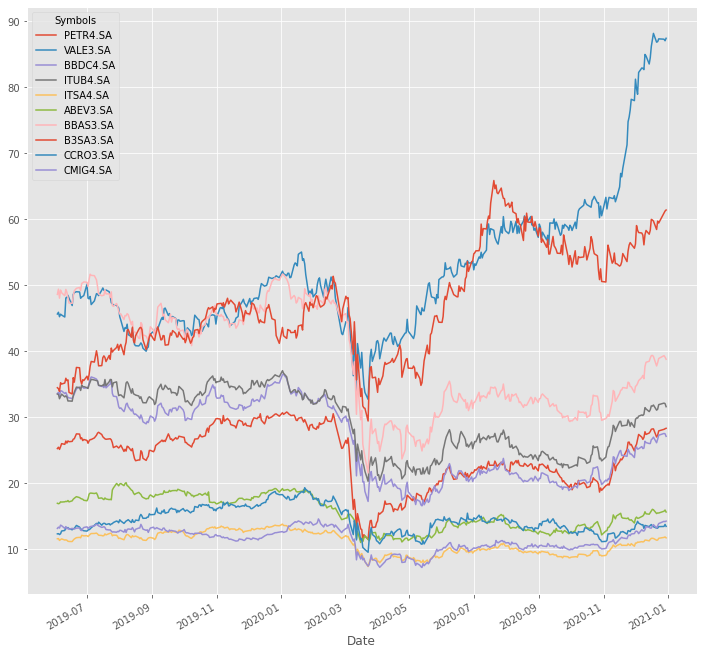

In [7]:
df_final.plot(figsize = (12, 12));

In [8]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 392 entries, 2019-06-03 to 2020-12-30
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PETR4.SA  392 non-null    float64
 1   VALE3.SA  392 non-null    float64
 2   BBDC4.SA  392 non-null    float64
 3   ITUB4.SA  392 non-null    float64
 4   ITSA4.SA  392 non-null    float64
 5   ABEV3.SA  392 non-null    float64
 6   BBAS3.SA  392 non-null    float64
 7   B3SA3.SA  392 non-null    float64
 8   CCRO3.SA  392 non-null    float64
 9   CMIG4.SA  392 non-null    float64
dtypes: float64(10)
memory usage: 33.7 KB


In [9]:
# Vamos visualizar algumas estatísticas descritivas
df_final.describe().round(2)

Symbols,PETR4.SA,VALE3.SA,BBDC4.SA,ITUB4.SA,ITSA4.SA,ABEV3.SA,BBAS3.SA,B3SA3.SA,CCRO3.SA,CMIG4.SA
count,392.00,392.00,392.00,392.00,392.00,392.00,392.00,392.00,392.00,392.00
mean,24.07,52.09,26.70,29.48,10.98,15.57,38.78,47.22,14.43,11.53
std,4.47,10.68,5.98,4.89,1.63,2.59,7.95,8.22,1.96,1.75
min,11.29,32.73,16.58,20.31,7.39,11.03,21.57,29.45,9.55,7.24
25%,21.40,44.83,20.77,24.32,9.53,13.25,32.11,41.19,13.02,10.38
50%,25.03,49.16,26.65,31.12,11.34,15.34,38.86,46.11,14.14,11.68
75%,27.42,58.11,32.34,33.87,12.44,17.98,46.14,54.67,15.94,12.99
max,30.81,88.19,36.52,37.07,13.81,20.10,51.72,65.89,19.33,14.60


Vamos normalizar nossos dados, a partir do log retorno de cada ativo. Felizmente é bastante simples fazer isto com objetos da biblioteca pandas.

In [10]:
df_log = np.log(df_final/df_final.shift(1))

In [11]:
df_log.head()

Symbols,PETR4.SA,VALE3.SA,BBDC4.SA,ITUB4.SA,ITSA4.SA,ABEV3.SA,BBAS3.SA,B3SA3.SA,CCRO3.SA,CMIG4.SA
Date,,,,,,,,,,
2019-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-04,0.008048,0.005718,0.005067,-0.001712,0.002412,-0.004026,0.016186,-0.004118,0.002277,0.013514
2019-06-05,-0.013062,-0.014770,-0.015504,-0.019609,-0.024391,0.003452,-0.027966,-0.011900,-0.010671,-0.010120
2019-06-06,0.016111,0.008437,0.021693,0.010429,0.011457,0.013124,0.025128,0.037699,0.009912,0.033333
2019-06-07,0.018100,-0.002873,0.000268,0.010606,0.008910,-0.001702,-0.008179,-0.005646,0.032839,-0.006576


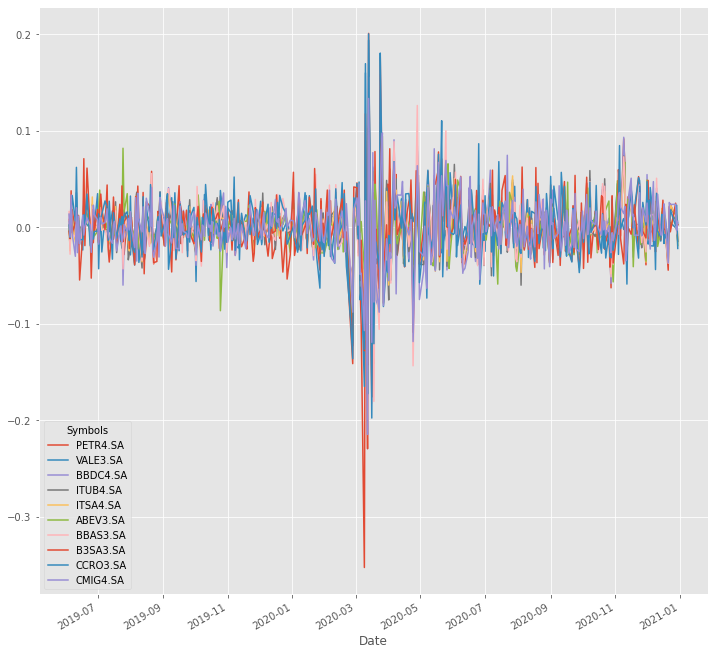

In [12]:
df_log.plot(figsize = (12, 12));

# Correlograma dos retornos

In [13]:
import seaborn as sns

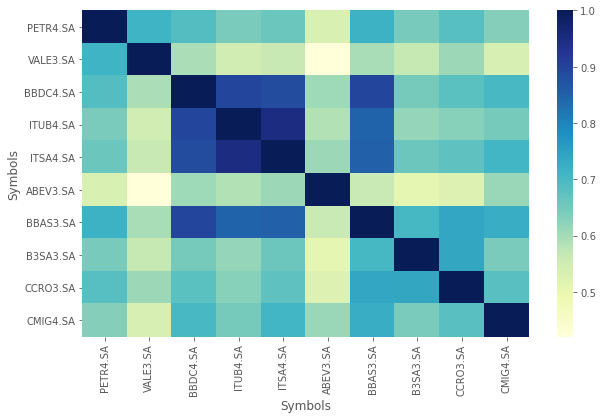

In [14]:
plt.figure(figsize = (10, 6))
sns.heatmap(df_log.corr(), cmap = "YlGnBu", square = False);

Nesta análise de correlograma, podemos ver a correlação dos retornos. Na diagonal sempre vamos ter correlação máxima, pois se trata da correlação do ativo com ele mesmo. Quanto mais escura a cor, mais forte a correlação.

Vamos explorar mais um pouco estas correlações e a partir de um loop visualizar, por ativo, quais as correlações mais fortes.

In [15]:
for ticker in df_log.columns:
    print('-=' * 15)
    print(f'Resultado para {ticker}'.center(30))
    print('-=' * 15)
    display(df_log.corr()[ticker].round(4).sort_values(ascending = False)[1:])

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
   Resultado para PETR4.SA    
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


Symbols
BBAS3.SA    0.7175
VALE3.SA    0.7139
BBDC4.SA    0.6884
CCRO3.SA    0.6834
ITSA4.SA    0.6617
B3SA3.SA    0.6470
ITUB4.SA    0.6446
CMIG4.SA    0.6331
ABEV3.SA    0.5338
Name: PETR4.SA, dtype: float64

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
   Resultado para VALE3.SA    
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


Symbols
PETR4.SA    0.7139
CCRO3.SA    0.6101
BBAS3.SA    0.5953
BBDC4.SA    0.5945
B3SA3.SA    0.5663
ITSA4.SA    0.5653
ITUB4.SA    0.5452
CMIG4.SA    0.5352
ABEV3.SA    0.4208
Name: VALE3.SA, dtype: float64

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
   Resultado para BBDC4.SA    
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


Symbols
BBAS3.SA    0.8977
ITUB4.SA    0.8962
ITSA4.SA    0.8856
CMIG4.SA    0.7035
PETR4.SA    0.6884
CCRO3.SA    0.6802
B3SA3.SA    0.6493
ABEV3.SA    0.6064
VALE3.SA    0.5945
Name: BBDC4.SA, dtype: float64

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
   Resultado para ITUB4.SA    
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


Symbols
ITSA4.SA    0.9488
BBDC4.SA    0.8962
BBAS3.SA    0.8484
CMIG4.SA    0.6474
PETR4.SA    0.6446
CCRO3.SA    0.6302
B3SA3.SA    0.6173
ABEV3.SA    0.5882
VALE3.SA    0.5452
Name: ITUB4.SA, dtype: float64

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
   Resultado para ITSA4.SA    
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


Symbols
ITUB4.SA    0.9488
BBDC4.SA    0.8856
BBAS3.SA    0.8521
CMIG4.SA    0.7101
CCRO3.SA    0.6758
PETR4.SA    0.6617
B3SA3.SA    0.6584
ABEV3.SA    0.6105
VALE3.SA    0.5653
Name: ITSA4.SA, dtype: float64

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
   Resultado para ABEV3.SA    
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


Symbols
CMIG4.SA    0.6111
ITSA4.SA    0.6105
BBDC4.SA    0.6064
ITUB4.SA    0.5882
BBAS3.SA    0.5620
PETR4.SA    0.5338
CCRO3.SA    0.5247
B3SA3.SA    0.5112
VALE3.SA    0.4208
Name: ABEV3.SA, dtype: float64

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
   Resultado para BBAS3.SA    
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


Symbols
BBDC4.SA    0.8977
ITSA4.SA    0.8521
ITUB4.SA    0.8484
CCRO3.SA    0.7404
CMIG4.SA    0.7265
PETR4.SA    0.7175
B3SA3.SA    0.7057
VALE3.SA    0.5953
ABEV3.SA    0.5620
Name: BBAS3.SA, dtype: float64

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
   Resultado para B3SA3.SA    
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


Symbols
CCRO3.SA    0.7393
BBAS3.SA    0.7057
ITSA4.SA    0.6584
BBDC4.SA    0.6493
PETR4.SA    0.6470
CMIG4.SA    0.6427
ITUB4.SA    0.6173
VALE3.SA    0.5663
ABEV3.SA    0.5112
Name: B3SA3.SA, dtype: float64

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
   Resultado para CCRO3.SA    
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


Symbols
BBAS3.SA    0.7404
B3SA3.SA    0.7393
PETR4.SA    0.6834
CMIG4.SA    0.6814
BBDC4.SA    0.6802
ITSA4.SA    0.6758
ITUB4.SA    0.6302
VALE3.SA    0.6101
ABEV3.SA    0.5247
Name: CCRO3.SA, dtype: float64

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
   Resultado para CMIG4.SA    
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


Symbols
BBAS3.SA    0.7265
ITSA4.SA    0.7101
BBDC4.SA    0.7035
CCRO3.SA    0.6814
ITUB4.SA    0.6474
B3SA3.SA    0.6427
PETR4.SA    0.6331
ABEV3.SA    0.6111
VALE3.SA    0.5352
Name: CMIG4.SA, dtype: float64

# Análise por Índice de Sharpe

Iremos nesta etapa da análise simular 5000 carteiras e computar, por carteira, o índice de Sharp obtido. O índice de Sharp é uma medida que nos informa o retorno adicional por incremento de risco (desvio padrão).

In [16]:
np.random.seed(42)
n_carteiras = 5000
all_weights = np.zeros((n_carteiras, len(df_log.columns)))
ret_arr, vol_arr, sharpe_arr = np.zeros(n_carteiras), np.zeros(n_carteiras), np.zeros(n_carteiras)

for x in range(n_carteiras):
    # Pesos
    weights = np.array(np.random.random(len(tickers)))
    weights = weights / np.sum(weights)
    
    # Salvando os pesos
    all_weights[x, :] = weights
    
    # Retorno esperado
    ret_arr[x] = np.sum((df_log.mean() * weights))
    
    # Volatilidade esperada
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(df_log.cov(), weights)))
    
    # Índice de Sharpe
    sharpe_arr[x] = ret_arr[x] / vol_arr[x]

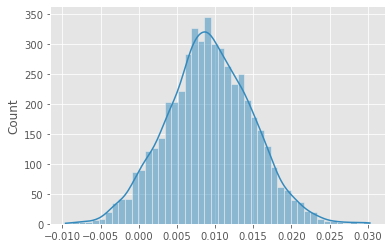

In [17]:
# Distribuição dos índices simulados
sns.histplot(sharpe_arr, kde = True);

Vamos agora visualizar qual o máximo Sharpe encontrado e verificar qual o respectivo vetor de pesos.

In [18]:
print(f'índice de Sharp máximo: {sharpe_arr.max():.4f}')

índice de Sharp máximo: 0.0303


In [19]:
pesos_is = all_weights[sharpe_arr.argmax(), :]
print('-=' * 15)
print('Portfólio selecionado'.center(30))
print('-=' * 15)
for i in range(len(tickers)):
    print(f'{tickers[i]}: {pesos_is[i] * 100:.2f}%')

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    Portfólio selecionado     
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
PETR4.SA: 8.19%
VALE3.SA: 25.87%
BBDC4.SA: 0.96%
ITUB4.SA: 2.30%
ITSA4.SA: 8.28%
ABEV3.SA: 6.04%
BBAS3.SA: 7.01%
B3SA3.SA: 24.13%
CCRO3.SA: 17.03%
CMIG4.SA: 0.17%


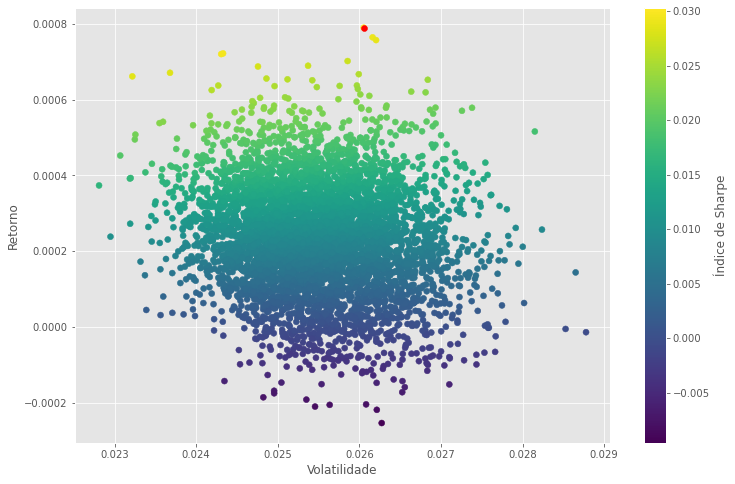

In [20]:
plt.figure(figsize = (12, 8))
plt.scatter(vol_arr, ret_arr, c = sharpe_arr, cmap = 'viridis')
plt.colorbar(label = 'Índice de Sharpe')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')

# Retorno e volatilidade da carteira com máximo Sharpe
plt.scatter(vol_arr[sharpe_arr.argmax()], ret_arr[sharpe_arr.argmax()], c = 'red');

# Implementando Markowitz 

In [21]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(df_log.mean() * weights)
    vol = np.sqrt(np.dot(weights.T, np.dot(df_log.cov(), weights)))
    sr = ret / vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * - 1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights) - 1

In [22]:
from scipy.optimize import minimize

In [23]:
cons = ({'type':'eq', 'fun':check_sum})
bounds = ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1))
init_guess = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [24]:
otim_resultados = minimize(neg_sharpe, init_guess, method = 'SLSQP', bounds = bounds, constraints = cons)

In [25]:
print(otim_resultados)

     fun: -0.05894063575882467
     jac: array([ 5.15551036e-02, -4.74834815e-06,  6.50799386e-02,  4.09647776e-02,
        3.33977784e-02,  3.54414159e-02,  7.14426404e-02,  1.03362836e-05,
        4.64942688e-02,  3.40193016e-02])
 message: 'Optimization terminated successfully'
    nfev: 99
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.00000000e+00, 6.85205536e-01, 5.27098651e-17, 2.84316436e-17,
       0.00000000e+00, 9.42996792e-18, 5.82884321e-18, 3.14794464e-01,
       0.00000000e+00, 0.00000000e+00])


In [26]:
print(f"índice de Sharp máximo: {get_ret_vol_sr(otim_resultados['x'])[2]:.4f}")

índice de Sharp máximo: 0.0589


In [27]:
pesos_mark = otim_resultados['x']
print('-=' * 15)
print('Portfólio selecionado'.center(30))
print('-=' * 15)
for i in range(len(tickers)):
    print(f'{tickers[i]}: {pesos_mark[i] * 100:.4f}%')

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    Portfólio selecionado     
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
PETR4.SA: 0.0000%
VALE3.SA: 68.5206%
BBDC4.SA: 0.0000%
ITUB4.SA: 0.0000%
ITSA4.SA: 0.0000%
ABEV3.SA: 0.0000%
BBAS3.SA: 0.0000%
B3SA3.SA: 31.4794%
CCRO3.SA: 0.0000%
CMIG4.SA: 0.0000%


In [28]:
resultados_mark = get_ret_vol_sr(otim_resultados['x'])
resultados_is = get_ret_vol_sr(pesos_is)

In [29]:
print(f'Método de Markowitz | Retorno de {resultados_mark[0]:.4f} e {resultados_mark[1]:.4f} de volatilidade')
print(f'Por índice de Sharpe | Retorno de {resultados_is[0]:.4f} e {resultados_is[1]:.4f} de volatilidade')

Método de Markowitz | Retorno de 0.0016 e 0.0272 de volatilidade
Por índice de Sharpe | Retorno de 0.0008 e 0.0261 de volatilidade


# Referências

[1] <a href="https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1540-6261.1952.tb01525.x">Paper original</a>

[2] <a href="https://towardsdatascience.com/python-markowitz-optimization-b5e1623060f5">Código de referência</a>